#Packages

In [1]:
!pip install Pillow

In [2]:
!pip install opencv-python

In [3]:
import os
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import os
from PIL import Image
from datetime import datetime

!pip install lightning

import logging
import typing
import logging
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

!pip install torchvision

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger, WandbLogger

import torchvision

from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, \
ToPILImage, Resize, ColorJitter, RandomRotation, RandomAffine, RandomErasing
from torchvision.datasets import ImageFolder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 58.8 MB/s eta 0:00:00


#HelpFunctions

##Transformers
This class provides a template for implementing custom transformers in a data processing pipeline. Subclasses are expected to override the `__call__` method to define the specific transformation logic for the data and labels. The class also includes logging capabilities for convenient debugging and monitoring.

Specific transformers are then as follows:

In [4]:
class ImageShowMatplotlib:
    """Show image for visual inspection using matplotlib
    """
    def __init__(
        self,
        verbose: bool = True,
        log_level: int = logging.INFO,
        name: str = "Image"
        ) -> None:
        """
        Args:
            verbose (bool): Whether to log label
            log_level (int): Logging level (default: logging.INFO)
            name (str): Name of window to show image
        """
        self.verbose = verbose
        self.name = name

    def __call__(self, image: Image.Image, label: typing.Any) -> typing.Tuple[Image.Image, typing.Any]:
        """ Show image for visual inspection using matplotlib

        Args:
            image (Image.Image): Image data
            label (typing.Any): Label data

        Returns:
            image (Image.Image): Image data
            label (typing.Any): Label data (unchanged)
        """
        if self.verbose:
            if isinstance(label, (str, int, float)):
                self.logger.info(f"Label: {label}")

        plt.imshow(np.array(image))
        plt.title(self.name)
        plt.show()

        if isinstance(label, Image.Image):
            plt.imshow(np.array(label))
            plt.title(self.name + " Label")
            plt.show()

        return image, label

##Randomness decorator
It provides a way to introduce randomness to the augmentation process, and it ensures type checking for the data parameter.

In [5]:
def randomness_decorator(func):
    # Decorator for randomness

    def wrapper(self, data: Image, annotation: typing.Any) -> typing.Tuple[Image, typing.Any]:
        """ Decorator for randomness and type checking

        Args:
            data (Image): Image object to be adjusted
            annotation (typing.Any): Annotation to be adjusted

        Returns:
            data (Image): Adjusted image
            annotation (typing.Any): Adjusted annotation
        """
        # Check if 'data' is an instance of the 'Image' class
        if not isinstance(data, Image):
            # Log an error if 'data' is not an Image object
            self.logger.error(f"data must be Image object, not {type(data)}, skipping augmentor")
            # TODO instead of error, convert image into Image object
            return data, annotation

        # Apply randomness: if random condition is not met, return original data
        if np.random.rand() > self._random_chance:
            return data, annotation

        # Return the result of the original function
        return func(self, data, annotation)

    return wrapper

##Augmentor
This class serves as a base class for augmentors, providing a common structure for image augmentation operations. They are used to introduce variability and improve the model's generalization.

#Download_and_unzip

In [6]:
def download_and_unzip(url, extract_to='Datasets', chunk_size=1024*1024):
    http_response = urlopen(url)

    data = b''
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

#Get data

In [7]:
dataset_path = os.path.join('Datasets', 'IAM_Words')
if not os.path.exists(dataset_path):
    download_and_unzip('https://git.io/J0fjL', extract_to='Datasets')

    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))


dataset, vocab, max_len = [], set(), 0

# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(os.path.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3] # extract the folder name
    folder2 = "-".join(line_split[0].split("-")[:2]) # extract the sub-folder name
    file_name = line_split[0] + ".png" # extract the file name
    label = line_split[-1].rstrip('\n') # the label, last element of row, remove the \n at the end

    # the relative path to the image file
    rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
    try:
        # Attempt to open the image
        image = Image.open(rel_path).convert("RGB")
    except (Image.UnidentifiedImageError, OSError) as e:
        print(f"Error opening image: {rel_path}, {e}")
        continue

    # append path and the label to dataset
    dataset.append([rel_path, label])

    # append label to vocab
    vocab.update(list(label))

    # length of the longest word
    max_len = max(max_len, len(label))

  4%|▍         | 4691/115338 [00:02<00:44, 2486.43it/s]

Error opening image: Datasets/IAM_Words/words/a01/a01-117/a01-117-05-02.png, cannot identify image file 'Datasets/IAM_Words/words/a01/a01-117/a01-117-05-02.png'


 99%|█████████▉| 113909/115338 [00:40<00:00, 2451.22it/s]

Error opening image: Datasets/IAM_Words/words/r06/r06-022/r06-022-03-05.png, cannot identify image file 'Datasets/IAM_Words/words/r06/r06-022/r06-022-03-05.png'


100%|██████████| 115338/115338 [00:41<00:00, 2770.75it/s]


In [8]:
vocab = "".join(sorted(vocab))

In [9]:
print(vocab)

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [10]:
labelx = ['peter', 'america', ',', 'you']

indices_array = np.array([vocab.index(l) for word in labelx for l in word if l in vocab])
print(indices_array)

[67 56 71 56 69 52 64 56 69 60 54 52  9 76 66 72]


In [35]:
reconstructed_word = ''.join(vocab[i] for i in indices_array)
print(reconstructed_word)

peteramerica,you


#Convolution block

In [11]:
def activation_layer(activation: str="relu", alpha: float=0.1, inplace: bool=True):
    """ Activation layer wrapper for LeakyReLU and ReLU activation functions

    Args:
        activation: str, activation function name (default: 'relu')
        alpha: float (LeakyReLU activation function parameter)

    Returns:
        torch.Tensor: activation layer
    """
    if activation == "relu":
        return nn.ReLU(inplace=inplace)

    elif activation == "leaky_relu":
        return nn.LeakyReLU(negative_slope=alpha, inplace=inplace)


class ConvBlock(nn.Module):
    """ Convolutional block with batch normalization
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        return self.bn(self.conv(x))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_conv=True, stride=1, dropout=0.2, activation="leaky_relu"):
        super(ResidualBlock, self).__init__()
        self.convb1 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.act1 = activation_layer(activation)

        self.convb2 = ConvBlock(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.dropout = nn.Dropout(p=dropout)

        self.shortcut = None
        if skip_conv:
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

        self.act2 = activation_layer(activation)

    def forward(self, x):
        skip = x

        out = self.act1(self.convb1(x))
        out = self.convb2(out)

        if self.shortcut is not None:
            out += self.shortcut(skip)

        out = self.act2(out)
        out = self.dropout(out)

        return out

#DataModule

In [26]:
class IAMWordsDataset(Dataset):
    def __init__(self, dataset, vocab, max_len, split="train", train_val_split=0.9):
        self.dataset = dataset
        self.vocab = vocab
        self.max_len = max_len
        self.split = split
        self.train_val_split = train_val_split

        # maybe it should be assigned own vocab and max_len to train/val dataset, but idk
        if self.split == "train":
            self.dataset = self.dataset[:int(len(self.dataset) * self.train_val_split)]
        elif self.split == "val":
            self.dataset = self.dataset[int(len(self.dataset) * self.train_val_split):]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset[idx]
        image = Image.open(image_path).convert("RGB")
#------------------------------------------------------------------------------
        #print("Hello World")
        #torch.cuda.synchronize(print(f"Loaded image size: {image.size}"))
#------------------------------------------------------------------------------
        return image, label


class TextRecognitionDataModule(pl.LightningDataModule):
    def __init__(self, dataset, vocab, max_len, batch_size=16):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = dataset
        self.vocab = vocab
        self.max_len = max_len

    def setup(self, stage=None):
        # Load dataset and build normalizer
        self.train_dataset = IAMWordsDataset(self.dataset, self.vocab, self.max_len, split="train")
        self.val_dataset = IAMWordsDataset(self.dataset, self.vocab, self.max_len, split="val")


    def train_dataloader(self):
        print("Train Dataloader called")
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          collate_fn=lambda batch: self.custom_collate(batch))

    def val_dataloader(self):
        print("Validation Dataloader called")
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          collate_fn=lambda batch: self.custom_collate(batch))

    # ensure the same size of images and convert it to tensor
    def custom_collate(self, batch):
        images, labels = zip(*batch)
        #print(labels)

        #--------------------------------------------------------------------
        # Print the shape of images before processing
        #for img in images:
            #print(f"Original image size: {img.size}")
        #--------------------------------------------------------------------

        # Resize all images to a consistent size (e.g., 128x32)
        transform = transforms.Compose([
            Resize((128, 32)),
            ColorJitter(brightness=0.5),
            RandomRotation(degrees=30),
            #RandomAffine(degrees=0, shear=10),
            #RandomAffine(degrees=0, translate=(0.1, 0.1)),
            #RandomAffine(degrees=0, scale=(0.8, 1.2)),
            #RandomErasing(),
            ToTensor()])

        images = [transform(image) for image in images]

        # Convert labels to integer tensors

        converted_labels = []
        for label in labels:
            converted_label = [self.vocab.index(l) for l in label if l in self.vocab]
            converted_labels.append(torch.tensor(converted_label, dtype=torch.long))

        #print(converted_labels)

        # Pad the labels to the same length for batch processing
        padded_labels = torch.nn.utils.rnn.pad_sequence(converted_labels,
                                                        batch_first=True,
                                                        padding_value=0)
        return torch.stack(images), padded_labels


#CNN model

In [13]:
class CNNmodel(pl.LightningModule):
    def __init__(self, pad_val, num_chars: int, activation: str="leaky_relu", dropout: float=0.2):
        super(CNNmodel, self).__init__()

        self.pad_val = pad_val

        self.rb1 = ResidualBlock(3, 16, skip_conv=True, stride=1, activation=activation, dropout=dropout)
        self.rb2 = ResidualBlock(16, 16, skip_conv=True, stride=2, activation=activation, dropout=dropout)
        self.rb3 = ResidualBlock(16, 16, skip_conv=False, stride=1, activation=activation, dropout=dropout)
        self.rb4 = ResidualBlock(16, 32, skip_conv=True, stride=2, activation=activation, dropout=dropout)
        self.rb5 = ResidualBlock(32, 32, skip_conv=False, stride=1, activation=activation, dropout=dropout)
        self.rb6 = ResidualBlock(32, 64, skip_conv=True, stride=2, activation=activation, dropout=dropout)
        self.rb7 = ResidualBlock(64, 64, skip_conv=True, stride=1, activation=activation, dropout=dropout)
        self.rb8 = ResidualBlock(64, 64, skip_conv=False, stride=1, activation=activation, dropout=dropout)
        self.rb9 = ResidualBlock(64, 64, skip_conv=False, stride=1, activation=activation, dropout=dropout)

        self.lstm = nn.LSTM(64, 128, bidirectional=True, num_layers=1, batch_first=True)
        self.lstm_dropout = nn.Dropout(p=dropout)

        self.output = nn.Linear(256, num_chars + 1)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        images_float = images / 255.0
        #images_float = images_float.permute(0, 3, 1, 2)

        #print(f"Shape after initial processing: {images_float.shape}")

#------------------------------------------------------------------------------
        x = self.rb1(images_float)
        #print(f"After rb1 Shape: {x.shape}")
        x = self.rb2(x)
        #print(f"After rb2 Shape: {x.shape}")
        x = self.rb3(x)
        #print(f"After rb3 Shape: {x.shape}")
        x = self.rb4(x)
        #print(f"After rb4 Shape: {x.shape}")
        x = self.rb5(x)
        #print(f"After rb5 Shape: {x.shape}")
        x = self.rb6(x)
        #print(f"After rb6 Shape: {x.shape}")
        x = self.rb7(x)
        #print(f"After rb7 Shape: {x.shape}")
        x = self.rb8(x)
        #print(f"After rb8 Shape: {x.shape}")
        x = self.rb9(x)
        #print(f"After rb9 Shape: {x.shape}")

        x = x.reshape(x.size(0), -1, x.size(1))
        #print(f"After Reshape Shape: {x.shape}")

        x, _ = self.lstm(x)
        x = self.lstm_dropout(x)
        #print(f"After LSTM Shape: {x.shape}")

        x = self.output(x)
        x = F.log_softmax(x, 2)
        #print(f"Final Output Shape: {x.shape}")
#------------------------------------------------------------------------------

        return x

    def training_step(self, batch, batch_idx):
        images, targets = batch

        outputs = self(images)

        target_lengths = torch.sum(targets != self.pad_val, dim=1)

        targets_unpadded = targets[targets != self.pad_val].view(-1)

        outputs = outputs.permute(1, 0, 2)  # (sequence_length, batch_size, num_classes)
        outputs_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)

        #print('Input lenghts tr', len(outputs_lengths))
        loss = F.ctc_loss(outputs, targets_unpadded, outputs_lengths, target_lengths, blank = self.pad_val)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch

        outputs = self(images)

        target_lengths = torch.sum(targets != self.pad_val, dim=1)

        targets_unpadded = targets[targets != self.pad_val].view(-1)

        outputs = outputs.permute(1, 0, 2)  # (sequence_length, batch_size, num_classes)
        outputs_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)

        #print('Input lenghts val', len(outputs_lengths))
        loss = F.ctc_loss(outputs, targets_unpadded, outputs_lengths, target_lengths, blank = self.pad_val)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [14]:
print(torch.cuda.is_available())

True


#Train model

In [17]:
# Initialize the model and data module
data_module = TextRecognitionDataModule(dataset, vocab, max_len)
model = CNNmodel(pad_val = 0, num_chars=len(vocab))
'''len(data_module.train_dataset.vocab)'''

# Prepare the data module for training
data_module.setup('train')

#------------------------------------------------------------------------------
# Test DataLoader

print("Testing DataLoader...")
#------------------------------------------------------------------------------

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

logger = CSVLogger("logs", name="TextRecognition")

# Train and Validate the model
trainer = pl.Trainer(logger=CSVLogger("logs", name="TextRecognition"), devices=ngpus, accelerator="gpu" if ngpus > 0 else None, max_epochs=1)
trainer.fit(model, data_module)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader...


INFO: 
   | Name         | Type          | Params
------------------------------------------------
0  | rb1          | ResidualBlock | 2.9 K 
1  | rb2          | ResidualBlock | 5.0 K 
2  | rb3          | ResidualBlock | 4.7 K 
3  | rb4          | ResidualBlock | 14.6 K
4  | rb5          | ResidualBlock | 18.6 K
5  | rb6          | ResidualBlock | 57.8 K
6  | rb7          | ResidualBlock | 74.1 K
7  | rb8          | ResidualBlock | 74.1 K
8  | rb9          | ResidualBlock | 74.1 K
9  | lstm         | LSTM          | 198 K 
10 | lstm_dropout | Dropout       | 0     
11 | output       | Linear        | 20.3 K
------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.179     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
   | Name         | Type          | Params
------------------------------------------------
0  | rb1          | ResidualBlock | 2.9 K 
1  | rb2          | Res

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation Dataloader called
Train Dataloader called


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


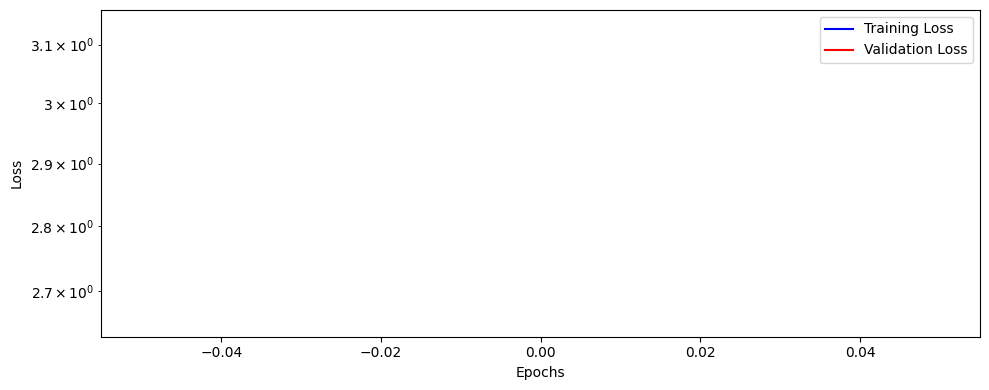

In [19]:
log_dir = 'version_1'

def plot_csv_losses(df_cleaned):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df_cleaned['epoch'], df_cleaned['train_loss_epoch'], label='Training Loss', c='b')
    plt.plot(df_cleaned['epoch'], df_cleaned['val_loss_epoch'], label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

log_file = f'/content/logs/TextRecognition/{log_dir}/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
plot_csv_losses(df_grouped)

In [20]:
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.3 MB/s eta 0:00:00


In [40]:
import Levenshtein
import torch.nn.functional as F

def decode_ctc(output, blank_label=0):
    """
    Decodes a sequence output from a CTC network.

    Args:
        output (torch.Tensor): The output from the CTC network.
        blank_label (int): The label used for the CTC blank symbol.

    Returns:
        list: The decoded sequence.
    """
    decoded_sequences = []
    output_argmax = output.argmax(dim=2)
    output_argmax = output_argmax.squeeze(1).cpu().numpy()

    for sequence in output_argmax:
        # Collapse repeated characters and remove blanks
        decoded_sequence = []
        prev_char = None
        for char in sequence:
            if char != prev_char and char != blank_label:
                decoded_sequence.append(char)
            prev_char = char
        decoded_sequences.append(decoded_sequence)

    return decoded_sequences

def correct(model, loader, blank_label=0):
    model.eval()
    device = next(model.parameters()).device

    cer_results = []
    correct_results = 0
    total_results = 0
    true_strings = []
    pred_strings = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y_hat = model(x)
            y_hat_softmax = F.log_softmax(y_hat, 2)

            y_un = []
            for i in y:
              unpad = i[i != blank_label]
              if unpad == []:
                unpad = [0]
              y_un.append(unpad)
            #print(y_un)

            # CTC decode
            decoded_seqs = decode_ctc(y_hat_softmax, blank_label)

            for true_seq, pred_seq in zip(y_un, decoded_seqs):
                if pred_seq == []:
                  pred_seq = [0]
                true_str = ''.join([str(int(c)) for c in true_seq])
                pred_str = ''.join([str(c) for c in pred_seq])

                cer = Levenshtein.distance(true_str, pred_str) / max(len(true_str), len(pred_str))
                cer_results.append(cer)

                correct_results += (true_str == pred_str)
                total_results += 1

                true_strings.append(true_str)
                pred_strings.append(pred_str)

    model.train()
    return correct_results, total_results, cer_results, true_strings, pred_strings

train_correct, train_total, train_cer, train_true_strings, train_pred_strings = correct(model, data_module.train_dataloader())
print(f'Training set accuracy: {train_correct}/{train_total} correctly classified, an accuracy of {train_correct/train_total:.2f}%!')
print(f'Training set average CER: {sum(train_cer) / len(train_cer):.4f}')

val_correct, val_total, val_cer, val_true_strings, val_pred_strings = correct(model, data_module.val_dataloader())
print(f'Validation set accuracy: {val_correct}/{val_total} correctly classified, an accuracy of {val_correct/val_total:.2f}%!')
print(f'Validation set average CER: {sum(val_cer) / len(val_cer):.4f}')

Train Dataloader called
Training set accuracy: 12801/86808 correctly classified, an accuracy of 0.15%!
Training set average CER: 0.6384
Validation Dataloader called
Validation set accuracy: 1440/9646 correctly classified, an accuracy of 0.15%!
Validation set average CER: 0.6387


In [25]:
for i in range(min(5, len(train_true_strings))):
    print(f'True: {train_true_strings[i]}, Predicted: {train_pred_strings[i]}')

True: 527100000000, Predicted: 6066
True: 665700000000, Predicted: 5266
True: 52000000000, Predicted: 52
True: 567356657100000, Predicted: 7452
True: 9000000000, Predicted: 11
